In [125]:
!pip install -q yfinance
!pip install -q matplotlib
!pip install -q arch
!pip install -q scikit-learn --upgrade

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model 
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view as roll
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

import warnings

warnings.filterwarnings('ignore')

## Data delivery

### Returns, ranges, volumes, spreads

In [2]:
# first we download all the required data
data = yf.download([
                    "VLUE", "QUAL", "MTUM", "SIZE", "^GSPC", '^STOXX50E', 
                    '^HSI', '^N225', '^FTSE', '^GDAXI', '^RUT', 'EEM', 'VT', 
                    'USCI', '^SP500-15', 'GLD', 'CL=F', 'XLF', 'EUFN', '^VIX', 
                    'EURUSD=X', 'CNY=X', 'JPY=X', '^TNX', '^TYX', '^FVX', '^IRX'
                   ], 
                   start="2013-07-18", end="2024-04-15", threads=True
                  )[['Close', 'Open', 'High', 'Low', 'Volume']].convert_dtypes()

# then we drop zero-columns and fill nan and zero values with the previous ones 
data = data.drop(data.columns[(data.iloc[0, :] == 0) | ((data == 0).all())], axis=1).ffill()

[*********************100%%**********************]  27 of 27 completed


In [3]:
range = data['High'] - data['Low'] # sampling the range data
otoc = data['Close'] - data['Open'] # sampling the open-to-close return data 
ctoo = data['Open'].shift(1)[1:] - data['Close'][:-1].values # sampling close-to-open data
high = data['High']
low = data['Low']
volume = data['Volume']
spread_data = pd.DataFrame({
                            "30y to 5y spread": data[('Close', '^TYX')] - data[('Close', '^FVX')], 
                            '30y to 13w spread': data[('Close', '^TYX')] - data[('Close', '^IRX')], 
                            '5y to 13w spread': data[('Close', '^FVX')] - data[('Close', '^IRX')]
                           }) # sampling government bonds yield spreads

### Technical indicators

In [4]:
# Sampling technical indicators
tickers = data['Close'][['VLUE', 'QUAL', 'MTUM', 'SIZE', '^GSPC']]
otoc_tick = otoc[['VLUE', 'QUAL', 'MTUM', 'SIZE', '^GSPC']]

# momentums
mom_1 = tickers[1:] - tickers[:-1].values
mom_3 = tickers[3:] - tickers[:-3].values
mom_5 = tickers[5:] - tickers[:-5].values
mom_10 = tickers[10:] - tickers[:-10].values
mom_63 = tickers[63:] - tickers[:-63].values

# RSI
neg_signal = np.zeros(otoc_tick.shape)
pos_signal = np.zeros(otoc_tick.shape)
pos_signal[otoc_tick.values > 0]  += 1
neg_signal[otoc_tick.values < 0]  += 1
p_14 = roll(pos_signal, 14, axis=0).mean(axis=-1) / roll(neg_signal, 14, axis=0).mean(axis=-1)
p_63 = roll(pos_signal, 63, axis=0).mean(axis=-1) / roll(neg_signal, 63, axis=0).mean(axis=-1)
rsi_14 = 100 - 100 / (1 + p_14)
rsi_63 = 100 - 100 / (1 + p_63)
rsi_14[rsi_14 < 30] = 1
rsi_14[rsi_14 > 70] = 0
rsi_14[(rsi_14 >= 30) & (rsi_14 <= 70)] = .5
rsi_63[rsi_63 < 30] = 1
rsi_63[rsi_63 > 70] = 0
rsi_63[(rsi_63 > 30) & (rsi_63 < 70)] = .5


# SMA
ma_5 = roll(tickers, 5, axis=0).mean(axis=-1)
ma_10 = roll(tickers, 10, axis=0).mean(axis=-1)
ma_63 = roll(tickers, 63, axis=0).mean(axis=-1)

# MACD
def ema(series, n):
    alpha = 2 / (n + 1)
    EMA = np.zeros(series.shape)
    ema = series[0, :]
    EMA[0, :] = ema
    for i, _ in enumerate(EMA[1:, :]):
        EMA[i + 1, :] = (1 - alpha) * ema + alpha * series[i + 1, :]
        ema = EMA[i + 1, :]

    return EMA

def get_macd(series):
    series[26] = series[:26].mean(axis=0)
    ema_26 = ema(series[26:], 26)

    series[26] = series[14:26].mean(axis=0)
    ema_12 = ema(series[26:], 12)

    macd_1 = ema_12 - ema_26
    macd_1[9] = macd_1[:9].mean(axis=0)
    macd = ema(macd_1[9:], 9)

    return macd

macd_3 = get_macd(tickers.values)
macd = macd_3.copy()

macd[macd_3 < 0] = 1
macd[macd_3 > 0] = 0
macd[macd_3 == 0] = .5

# Bollinger bands
upper_bollinger = roll(tickers, 20, axis=0).mean(axis=-1) + 2 * roll(tickers.values.astype(float), 20, axis=0).std(axis=-1)
lower_bollinger = roll(tickers, 20, axis=0).mean(axis=-1) - 2 * roll(tickers.values.astype(float), 20, axis=0).std(axis=-1)

bollinger = np.ones(tickers.values[19:, :].shape) * .5
bollinger[tickers.values[19:, :] < lower_bollinger] = 1
bollinger[tickers.values[19:, :] > upper_bollinger] = 0

In [5]:
# Preparing all the data to be merged 

def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name
def todf(series, index):
    cols = get_var_name(series) + '_' + tickers.columns.values
    df = pd.DataFrame(series, columns=cols, index=index)
    return df
def col_rename(series):
    varname = get_var_name(series)
    for i, name in enumerate(series.columns):
        series.rename(columns={name: varname + '_' + name}, inplace=True)
    return series

index = tickers.index.values
rsi_14_df = todf(rsi_14, index[13:])
rsi_63_df = todf(rsi_63, index[62:])
ma_5_df = todf(ma_5, index[4:])
ma_10_df = todf(ma_10, index[9:])
ma_63_df = todf(ma_63, index[62:])
macd_df = todf(macd, index[35:])
bollinger_df = todf(bollinger, index[19:])
mom_1_df = col_rename(mom_1)
mom_3_df = col_rename(mom_3)
mom_5_df = col_rename(mom_5)
mom_10_df = col_rename(mom_10)
mom_63_df = col_rename(mom_63)

technical_data = rsi_14_df.join([
                                 rsi_63_df, ma_5_df, ma_10_df,
                                 ma_63_df, macd_df, bollinger_df,
                                 mom_1, mom_3, mom_5, mom_10, mom_63
                                ])
otoc_data = col_rename(otoc)
ctoo_data = col_rename(ctoo)
range_data = col_rename(range)
high_data = col_rename(high)
low_data = col_rename(low)
vol_data = col_rename(volume)

### Features and target assembling

In [32]:
# Merging (outer joining) data, droping constant columns and nan observations
# also droping CNY exchange rates because this data is not complete 

features = technical_data.join([otoc_data, ctoo_data, spread_data, 
                                range_data, low_data, high_data, vol_data], 
                               how='outer').convert_dtypes()
features = features.drop(features.columns[(features == 0).all()], axis=1).ffill().dropna()
features = features.drop(features.columns[(features == features.iloc[0]).all()], axis=1)
features.drop('otoc_CNY=X', inplace=True, axis=1)
features.shape

(2739, 211)

Target classes are sampled in the following way:
- If open-to-close ($otoc$) value is bigger than $thresh$ then $class=1$
- $0 \leq otoc \leq thresh \rightarrow class=2$
- $-thresh \leq otoc \leq 0 \rightarrow class=3$
- $otoc \leq -thresh \rightarrow class=4$

In [45]:
# while assembling features we lost first 63 obs., thus we need to shift data by [63:]
pct = data['Close'][63:][63:] / data['Close'][63:][:-63].values - 1 # open-to-close % returns
tickers = pct[['VLUE', 'QUAL', 'MTUM', 'SIZE']].values
dep_self = features[[
                    'otoc_VLUE', 'otoc_QUAL', 
                    'otoc_MTUM', 'otoc_SIZE'
                   ]].values[63:] # otoc values

thresh = 0.05 # threshold for target classes 
dep_self[tickers >= thresh] = 1
dep_self[(tickers < thresh) & (tickers >= 0)] = 2
dep_self[(tickers < 0)] = 3
#dep_self[tickers <= -thresh] = 4

# checking the distribution of classes
np.unique(dep_self, return_counts=True)

(array([1, 2, 3], dtype=object), array([3679, 3861, 3164], dtype=int64))

In [46]:
features = features.iloc[:-63, :]

In [47]:
# Min-Max scaling features 
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit(features).transform(features)

## Entropy

#### Algorithm

The ideal vector $v_i$ of all features for class $i$ is given as
$$
\large v_i=\left(\frac{1}{N_i}\sum_{x \in X_i}^{N_i}x^m\right)^{\frac{1}{m}}
$$
where, - $N_i$ - number of observations in a class $i$; $x$ is a features array of class $i$ observations; and $m$ is a parameter

The vector $S(x_j, v_i)$ of similarity between each ideal vector $v_i$ and each observation $x_j$ is given as
$$
\large S(x_j, v_i)=\sqrt[p]{1-|x_j^p-v_i^p|}
$$
where, $p$ - is a parameter

In [48]:
def get_S(features, classes, m=1, p=1):
    clas = np.unique(classes)
    S = np.zeros((clas.shape[0] * features.shape[0], features.shape[1]))
    V = np.zeros((clas.shape[0], features.shape[1]))
    N = features.shape[0]

    # in case of unscaled data:
    if features.max(axis=None) > 1:
        features = (features - features.min(axis=0)) / (features.max(axis=0) - features.min(axis=0))
    if features.min(axis=None) < 0:
        features = (features - features.min(axis=0)) / (features.max(axis=0) - features.min(axis=0))
        
    for n, i in enumerate(clas):
        x_obs = features[classes==i]
        num_obs = x_obs.shape[0]
        v = ((x_obs ** m).sum(axis=0) / num_obs) ** (1 / m)
        S_i = (1 - abs(v - features)) ** (1 / p)
        
        S[n * N : (n + 1) * N, :] += S_i
        V[n, :] += v

    return S, V

Entropy measure $H(A)$ of De Luca and Termini is
$$
\large H(A)=\sum^n_{i=1}\left[S_{j, i} \log S_{j, i} + (1 - S_{j, i}) \log(1 - S_{j, i})\right]
$$
where, $S_{j, i}$ is the similarity between each ideal vector $v_i$ and each observation $x_j$; $n$ - is the number of observations

Entropy values for each feature $d$ can be obtained as
$$
\large H_d=\sum^N_{i=1} \sum^n_{j=1} H(S(x_j, v_i))
$$
where, $N$ - the number of classes; $n$ is the number of observations; $S(x_j, v_i)$ is the similarity between each ideal vector $v_i$ and each observation $x_j$

And the scaled entropy for a feature d $SE_d$ is:
$$
\large SE_d = \sum^N_{i=1}\left(\sum^n_{j=1}H(S(x_j, v_i)) \right) * \left(1-\frac{\left(\sum_{o \neq j}|v_i - v_o|^l \right)^{\frac{1}{l}}}{N-1}\right)
$$

In [49]:
def get_SE(S, ideal_vec_matrix, l=1):
    V = ideal_vec_matrix
    N = V.shape[0]
    
    sum = -(S * np.log(S + np.exp(-20)) + (1 - S) * np.log(1 - S + np.exp(-20)))
    H = sum.sum(axis=0)

    SF = 1 - (abs((V[0, :] - V[:, :]) ** l).sum(axis=0)) ** (1 / l) / (N - 1)
    SE =  H * SF

    FL = 1 - (SE / SE.sum(axis=None))

    return SE, FL

#### Example

In [108]:
# Example
exm_dic = {'Feature 1': (5, 5.2, 5.1, 4.9),
           'Feature 2': (10, 30, 50, 70),
           'Class': (1, 1, 2, 2)}
exm = pd.DataFrame(exm_dic)
exm

,Feature 1,Feature 2,Class
0,5.0,10,1
1,5.2,30,1
2,5.1,50,2
3,4.9,70,2


In [403]:
SS, V = get_S(exm.iloc[:, :-1], exm.iloc[:, -1])
print(SS, '\n\n', V)

[[0.66666667 0.83333333]
 [0.66666667 0.83333333]
 [1.         0.5       ]
 [0.33333333 0.16666667]
 [1.         0.16666667]
 [0.33333333 0.5       ]
 [0.66666667 0.83333333]
 [0.66666667 0.83333333]] 

 [[0.66666667 0.16666667]
 [0.33333333 0.83333333]]


In [404]:
get_SE(SS, V)

(array([2.54605665, 1.36322053]), array([0.34871422, 0.65128578]))

## Building a model

#### Algorithm

In [50]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

What follows is a feature selection method based on an Entropy measure. On each step a Random Forest Classifier is trained, from which we obtain an accuracy score. The step ends with the removal of the feature with the highest Entropy, after which the process loops untill $n$ features are removed.

In [51]:
def iter(features, dependant, m=1, p=1, l=1, num_removed=1):
    dependant = dependant.astype(int)
    accuracies = []
    feat_index = np.arange(0, features.shape[1], 1)
    max_acc = 0

    for i in np.arange(num_removed):
        X_train, X_test, y_train, y_test = train_test_split(
                                features, dependant, test_size=.3, 
                                stratify=dependant, random_state=1984)
        
        clf = RandomForestClassifier(random_state=1984, n_jobs=-1)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        
        acc = accuracy_score(y_test, y_hat)
        accuracies.append(acc)
        if acc >= max_acc:
            max_acc = acc
            max_acc_data = feat_index.copy()
        
        SS, V = get_S(X_train, y_train, m, p)
        SE, _ = get_SE(SS, V, l)
        features = np.delete(features, SE.argmax(), 1)
        feat_index = np.delete(feat_index, SE.argmax())

    return accuracies, max_acc_data

By grid searching for best $m, p$ and $l$ parameters we estimate average accuracies, which will later be used to determine how many and which features to remove.

In [52]:
def grid_search(features, dependant, mlist, plist, llist):
    max_acc = 0
    acc_avg = np.zeros(features.shape[1])
    for m in mlist:
        for p in plist:
            for l in llist:
                acc, cols = iter(features, dependant, m, p, l, features.shape[1])
                acc_avg += np.array(acc)
                if max(acc) >= max_acc:
                    best_data = cols.copy()
                    best_params = {'m': m, 'p': p, 'l': l}
                    best_acc = acc.copy()
                    max_acc = max(acc)
    acc_avg = acc_avg / (len(mlist) * len(plist) * len(llist))
    return best_data, best_params, best_acc, acc_avg

#### SIZE

In [53]:
size = dep_self[:, 3]
cols, size_params, best_acc, avg_acc_size = grid_search(features, size, [1, 2, 3], [3, 4, 5], [2])

In [54]:
size_params

{'m': 3, 'p': 5, 'l': 2}

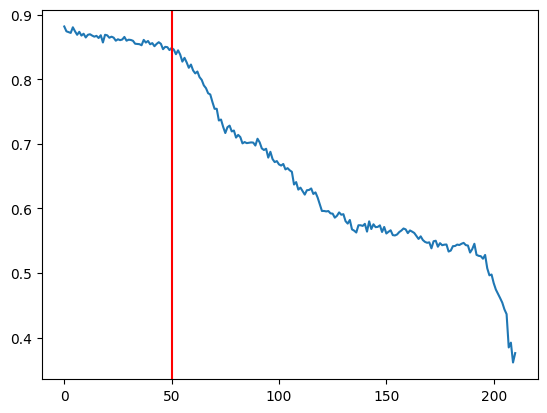

In [66]:
plt.plot(avg_acc_size)
plt.axvline(50, c='r')

In [67]:
acc, size_data = iter(features, size, m=size_params['m'], p=size_params['p'], l=size_params['l'], num_removed=50)

#### MTUM

In [57]:
mtum = dep_self[:, 2]
cols, mtum_params, best_acc, avg_acc_mtum = grid_search(features, mtum, [1, 2, 3], [3, 4, 5], [2])

In [58]:
mtum_params

{'m': 3, 'p': 5, 'l': 2}

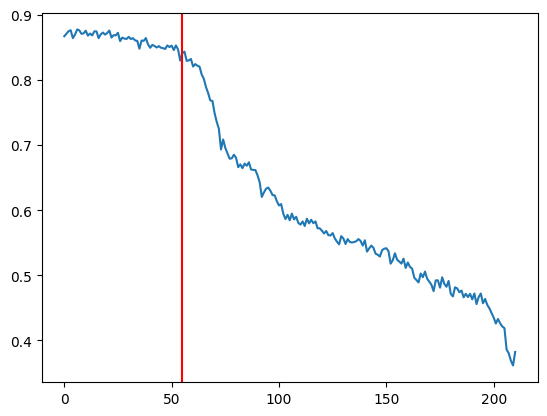

In [68]:
plt.plot(avg_acc_mtum)
plt.axvline(55, c='r')

In [71]:
acc, mtum_data = iter(features, mtum, m=mtum_params['m'], p=mtum_params['p'], l=mtum_params['l'], num_removed=55)

#### QUAL

In [60]:
qual = dep_self[:, 1]
cols, qual_params, best_acc, avg_acc_qual = grid_search(features, qual, [1, 2, 3], [3, 4, 5], [2])

In [61]:
qual_params

{'m': 1, 'p': 5, 'l': 2}

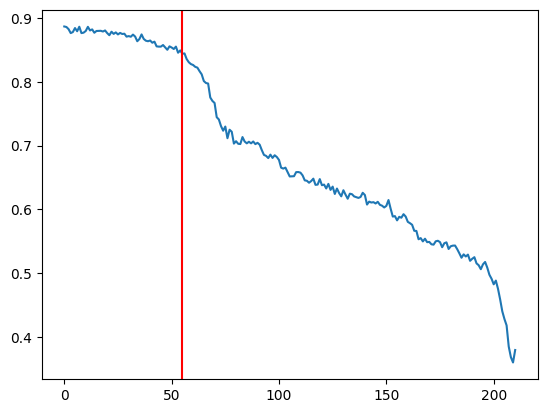

In [69]:
plt.plot(avg_acc_qual)
plt.axvline(55, c='r')

In [72]:
acc, qual_data = iter(features, qual, m=qual_params['m'], p=qual_params['p'], l=qual_params['l'], num_removed=55)

#### VLUE

In [63]:
vlue = dep_self[:, 0]

cols, params, best_acc, avg_acc_vlue = grid_search(features, vlue, [1, 2, 3], [3, 4, 5], [2])

In [64]:
vlue_par = params
vlue_par

{'m': 2, 'p': 4, 'l': 2}

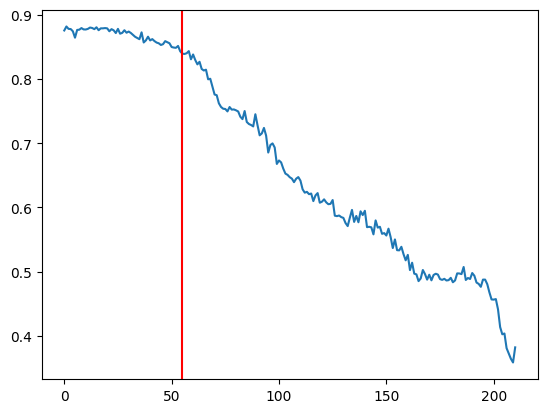

In [70]:
plt.plot(avg_acc_vlue)
plt.axvline(55, c='r')

In [73]:
acc, vlue_data = iter(features, vlue, m=vlue_par['m'], p=vlue_par['p'], l=vlue_par['l'], num_removed=55)

#### Saving

In [74]:
size_data = pd.DataFrame(features[:, size_data])
mtum_data = pd.DataFrame(features[:, mtum_data])
qual_data = pd.DataFrame(features[:, qual_data])
vlue_data = pd.DataFrame(features[:, vlue_data])

with pd.ExcelWriter("data_forecast_self.xlsx") as writer:
    size_data.to_excel(writer, sheet_name='size')
    mtum_data.to_excel(writer, sheet_name='mtum')
    qual_data.to_excel(writer, sheet_name='qual')
    vlue_data.to_excel(writer, sheet_name='vlue')

## Finetuning Random Forests

Using GridSearchCV with the default cross-validation Fold number of 5 to determine best RandomForestClassifier parameters for all indexes 

#### SIZE

In [75]:
size_data = pd.read_excel('data_forecast_self.xlsx', sheet_name='size')
size_data.set_index(size_data.iloc[:, 0], inplace=True)
size_data.drop('Unnamed: 0', inplace=True, axis=1)

size = dep_self[:, 0].astype(int)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
                                size_data, size, test_size=.3, 
                                stratify=size, random_state=1984)

rfc = RandomForestClassifier(random_state=1984, n_jobs=-1)
rfccv = GridSearchCV(rfc,
                      param_grid={'min_samples_split': np.arange(4, 16, 4),
                                  'min_samples_leaf': np.arange(4, 16, 4),
                                  'max_features': np.arange(.1, .7, .2)
                                  })
rfccv.fit(X_train, y_train)
size_best = rfccv.best_params_
size_best

{'max_features': 0.1, 'min_samples_leaf': 4, 'min_samples_split': 4}

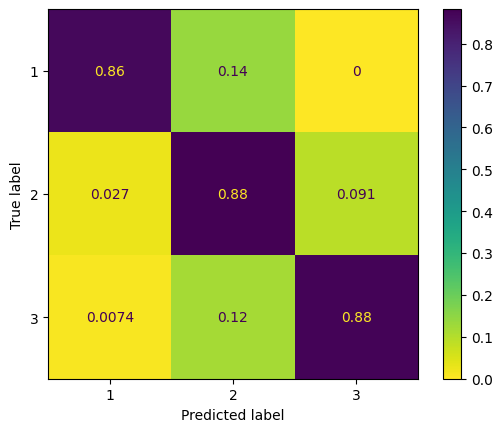

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
        rfccv,
        X_test,
        y_test,
        display_labels=rfccv.classes_,
        cmap=plt.cm.viridis_r,
        normalize='true',
    )

#### MTUM

In [79]:
mtum_data = pd.read_excel('data_forecast_self.xlsx', sheet_name='mtum')
mtum_data.set_index(mtum_data.iloc[:, 0], inplace=True)
mtum_data.drop('Unnamed: 0', inplace=True, axis=1)

mtum = dep_self[:, 2].astype(int)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
                                mtum_data, mtum, test_size=.3, 
                                stratify=mtum, random_state=1984)

rfc = RandomForestClassifier(random_state=1984, n_jobs=-1)
rfccv = GridSearchCV(rfc,
                      param_grid={'min_samples_split': np.arange(4, 16, 4),
                                  'min_samples_leaf': np.arange(4, 16, 4),
                                  'max_features': np.arange(.1, .7, .2)
                                  })
rfccv.fit(X_train, y_train)
mtum_best = rfccv.best_params_
mtum_best

{'max_features': 0.2, 'min_samples_leaf': 4, 'min_samples_split': 4}

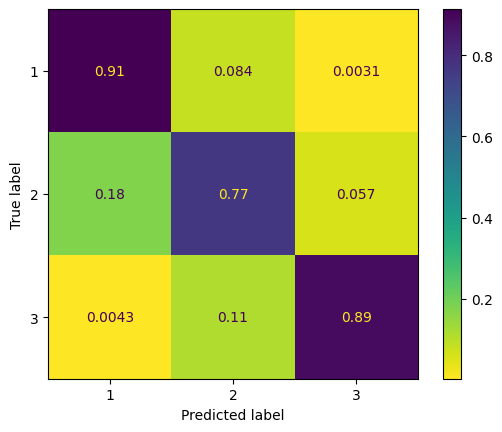

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
        rfccv,
        X_test,
        y_test,
        display_labels=rfccv.classes_,
        cmap=plt.cm.viridis_r,
        normalize='true',
    )

#### QUAL

In [83]:
qual_data = pd.read_excel('data_forecast_self.xlsx', sheet_name='qual')
qual_data.set_index(qual_data.iloc[:, 0], inplace=True)
qual_data.drop('Unnamed: 0', inplace=True, axis=1)

qual = dep_self[:, 1].astype(int)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
                                qual_data, qual, test_size=.4, 
                                stratify=qual, random_state=1984)

rfc = RandomForestClassifier(random_state=1984, n_jobs=-1)
rfccv = GridSearchCV(rfc,
                      param_grid={'min_samples_split': np.arange(4, 16, 4),
                                  'min_samples_leaf': np.arange(4, 16, 4),
                                  'max_features': np.arange(.1, .7, .2)
                                  })
rfccv.fit(X_train, y_train)
qual_best = rfccv.best_params_
qual_best

{'max_features': 0.30000000000000004,
 'min_samples_leaf': 4,
 'min_samples_split': 4}

In [85]:
np.unique(y_train, return_counts=True)

(array([1, 2, 3]), array([582, 605, 418], dtype=int64))

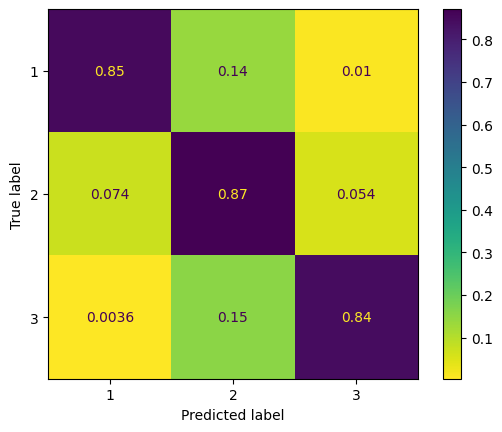

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
        rfccv,
        X_test,
        y_test,
        display_labels=rfccv.classes_,
        cmap=plt.cm.viridis_r,
        normalize='true',
    )

#### VLUE

In [87]:
vlue_data = pd.read_excel('data_forecast_self.xlsx', sheet_name='vlue')
vlue_data.set_index(vlue_data.iloc[:, 0], inplace=True)
vlue_data.drop('Unnamed: 0', inplace=True, axis=1)

vlue = dep_self[:, 0].astype(int)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
                                vlue_data, vlue, test_size=.3, 
                                stratify=vlue, random_state=1984)

rfc = RandomForestClassifier(random_state=1984, n_jobs=-1)
rfccv = GridSearchCV(rfc,
                      param_grid={'min_samples_split': np.arange(4, 16, 4),
                                  'min_samples_leaf': np.arange(4, 16, 4),
                                  'max_features': np.arange(.1, .7, .2)
                                  })
rfccv.fit(X_train, y_train)
vlue_best = rfccv.best_params_
vlue_best

{'max_features': 0.30000000000000004,
 'min_samples_leaf': 4,
 'min_samples_split': 12}

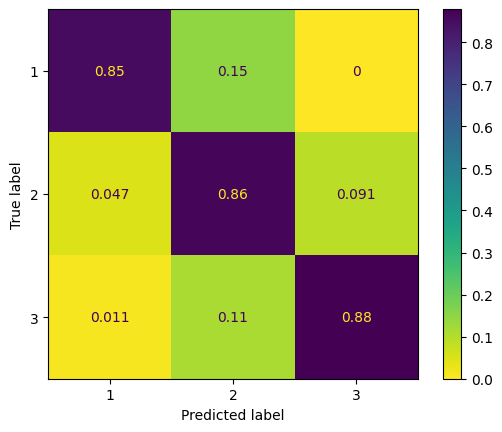

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
        rfccv,
        X_test,
        y_test,
        display_labels=rfccv.classes_,
        cmap=plt.cm.viridis_r,
        normalize='true',
    )

## Financial algorithm

Building a trading algorithm in which each quarter we make quarter-ahead forecasts. Negative forecasts (classe 3) suggest us to sell respective shares. Depending on the specific share Classifier accuracy (in confusion matrix) we sell different fractions of current shares. The money from selling shares are then partly or fully used to buy shares that are expecter to grow (classes 1 and 2), buying operations are also being done depending on the specific share Classifier accuracy (in confusion matrix). 

In [91]:
def one_norm(x):
    return x / abs(np.sum(x) + np.exp(-15))

In [93]:
def get_signals(forecast, weights_matrix):
    buy = np.zeros(forecast.shape[0])
    sell = np.zeros(forecast.shape[0])
    for i, w in enumerate(weights_matrix):
        if forecast[i] == 1:
            buy[i] = w[0]
        elif forecast[i] == 2:
            buy[i] = w[1]
        elif forecast[i] == 3:
            sell[i] = w[2]
    
    return buy, sell

In [100]:
from sklearn.model_selection import KFold

inv = 10**6
start = inv
sp_start = inv
hold_start = inv

reinv = 0

algorithm_logs = []
snp_logs = []
hold_logs = []

r = np.array([
              [.5, .5, .1],
              [.5, .5, .1],
              [.5, .5, .1],
              [.5, .5, .1]
             ])

close = data['Close'][['SIZE', 'MTUM', 'QUAL', 'VLUE']][63:-63]
sp_close = data['Close']['^GSPC'][63:-63].values

curr_stocks = start / 4 / close.values[0, :]
sp = sp_start / sp_close[0]
hold = hold_start / 4 / close.values[0, :]

for z, (train_index, test_index) in enumerate(KFold(n_splits=4).split(size)):  
    
    model_size = RandomForestClassifier(random_state=1984, n_jobs=-1, )
    model_mtum = RandomForestClassifier(random_state=1984, n_jobs=-1, )
    model_qual = RandomForestClassifier(random_state=1984, n_jobs=-1, )
    model_vlue = RandomForestClassifier(random_state=1984, n_jobs=-1, )

    model_size.fit(size_data.values[train_index, :], size[train_index])
    model_mtum.fit(mtum_data.values[train_index, :], mtum[train_index])
    model_qual.fit(qual_data.values[train_index, :], qual[train_index])
    model_vlue.fit(vlue_data.values[train_index, :], vlue[train_index])
    
    for i, curr_price in enumerate(close.values[test_index, :]):
        if i % 62 == 1: 
            forecast = np.array([
                 model_size.predict(size_data.values[test_index[i], :].reshape(1, -1))[0],
                 model_mtum.predict(mtum_data.values[test_index[i], :].reshape(1, -1))[0],
                 model_qual.predict(qual_data.values[test_index[i], :].reshape(1, -1))[0],
                 model_vlue.predict(vlue_data.values[test_index[i], :].reshape(1, -1))[0],
                                ]).astype(int)
            buy, sell = get_signals(forecast, r)
            
            reinv += (sell * curr_stocks * curr_price).sum() 
            curr_stocks -= curr_stocks * sell
            
            if (buy * curr_stocks * curr_price).sum() <= reinv:
                reinv -= (buy * curr_stocks * curr_price).sum()
                curr_stocks += buy * curr_stocks
            else: 
                curr_stocks += (one_norm(buy * curr_stocks * curr_price) * reinv) / curr_price
                reinv = 0
        algorithm_logs.append(np.round((curr_stocks * curr_price).sum()))
        snp_logs.append(np.round(sp * sp_close[test_index[i]]))
        hold_logs.append(np.round((hold * curr_price).sum()))

weights = one_norm(close.values[-1, :] * curr_stocks)

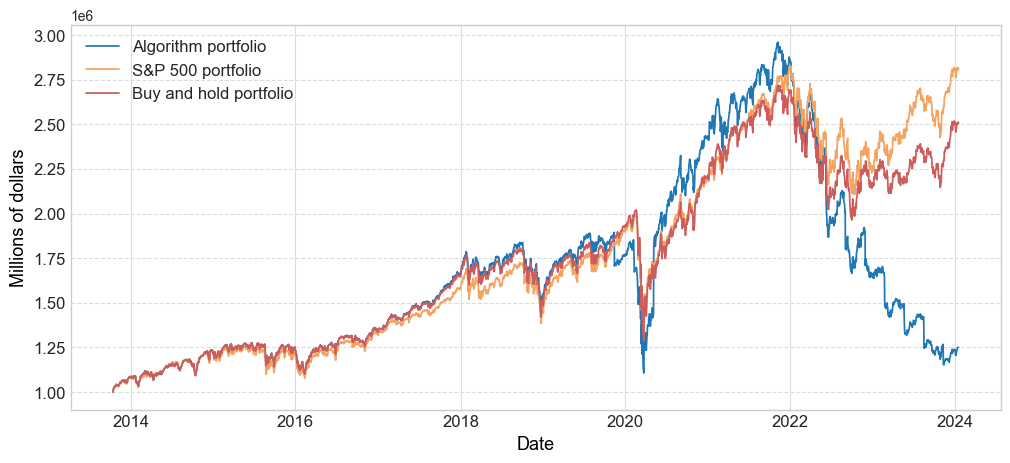

In [102]:
plt.figure(figsize=[12, 5])
plt.style.use("seaborn-v0_8-whitegrid")
index = close.index

plt.plot(index, algorithm_logs, color='C0',
         label='Algorithm portfolio', linewidth=1.25)
plt.plot(index, snp_logs, color='sandybrown',
         linewidth=1.25, label='S&P 500 portfolio')
plt.plot(index, hold_logs, color='indianred',
         linewidth=1.25, label='Buy and hold portfolio')

plt.xlabel('Date', fontsize = 13, color='black')
plt.ylabel('Millions of dollars', fontsize = 13, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='gainsboro')
plt.grid(axis ='y', which='major', linestyle='--', color='gainsboro')
plt.tick_params(axis='x', labelsize=12, color='black')
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=12)

#### Checking significance 

In [110]:
begin = pd.DataFrame()
begin['our algorithm'] = np.array(algorithm_logs)
begin['baseline'] = np.array(hold_logs)

begin = begin.iloc[1:, :] / begin.iloc[:-1, :].values - 1
begin.head()

,our algorithm,baseline
1,-0.088681,0.011630
2,0.007473,0.005834
3,0.003546,0.003756
4,0.002942,0.004451
5,0.006015,0.005713


In [111]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.api import het_breuschpagan

y = pd.DataFrame()
y['difference with baseline'] = begin.iloc[:, 0] - begin.iloc[:, 1]

X = pd.DataFrame()
X['const'] = np.ones(y.shape[0])

model_base = sm.OLS(y.values, X).fit()

BG_test = acorr_breusch_godfrey(model_base, nlags = 1)
#BP_test = het_breuschpagan(model_base.resid,  model_base.model.exog)

print('Breusch-Godfrey Statistic p-value:', np.round(BG_test[1], 2))
#print('Breusch-Pagan Statistic p-value:', np.round(BP_test[1], 2))

Breusch-Godfrey Statistic p-value: 1.0


Because the $p$-value $<0.05$ we encounter the error autocorrelation

In [112]:
model_robust_base = model_base.get_robustcov_results(cov_type = "HC1", use_t=None)
print(model_robust_base.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 27 May 2024   Prob (F-statistic):                nan
Time:                        15:27:34   Log-Likelihood:                 11517.
No. Observations:                2675   AIC:                        -2.303e+04
Df Residuals:                    2674   BIC:                        -2.303e+04
Df Model:                           0                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.384e-05   6.32e-05      0.377      0.7